In [2]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Dropout 
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from keras import regularizers
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42

In [5]:
df = pd.read_csv("./data/WISDM.csv")

df = df.drop(['Unnamed: 0', 'user-id', 'timestamp'], axis=1)

In [6]:
df

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
1098198,Sitting,9.000000,-1.570000,1.690000
1098199,Sitting,9.040000,-1.460000,1.730000
1098200,Sitting,9.080000,-1.380000,1.690000
1098201,Sitting,9.000000,-1.460000,1.730000


In [7]:
Jogging = df[df['activity']=='Jogging'].head(4500).copy()

In [8]:
Jogging

,activity,X,Y,Z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
13015,Jogging,5.434519,8.853226,3.909040
13016,Jogging,-4.331271,19.531578,-1.729784
13017,Jogging,-1.035146,-5.012288,-4.481094
13018,Jogging,7.082581,17.243360,-0.381370


In [9]:
Sitting = df[df['activity']=='Sitting'].head(4499).copy()

In [10]:
balanced_data = pd.DataFrame()

balanced_data = pd.concat([balanced_data, Jogging, Sitting])

balanced_data.shape

(8999, 4)

In [11]:
balanced_data['X'] = (balanced_data['X']-balanced_data['X'].min())/(balanced_data['X'].max()-balanced_data['X'].min())
balanced_data['Y'] = (balanced_data['Y']-balanced_data['Y'].min())/(balanced_data['Y'].max()-balanced_data['Y'].min())
balanced_data['Z'] = (balanced_data['Z']-balanced_data['Z'].min())/(balanced_data['Z'].max()-balanced_data['Z'].min())
balanced_data

,activity,X,Y,Z
0,Jogging,0.410987,0.791254,0.497158
1,Jogging,0.584056,0.748350,0.511587
2,Jogging,0.580752,0.736799,0.478356
3,Jogging,0.413465,0.967409,0.578050
4,Jogging,0.396117,0.773927,0.712287
...,...,...,...,...
255293,Sitting,0.301954,0.339938,0.747704
255294,Sitting,0.300741,0.341149,0.747704
255295,Sitting,0.299528,0.339938,0.749016
255296,Sitting,0.301954,0.339938,0.747704


In [12]:
balanced_data['activity'].value_counts()

Jogging    4500
Sitting    4499
Name: activity, dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

balanced_data['activity']=le.fit_transform(balanced_data['activity'])

In [14]:
balanced_data['activity'].value_counts()

0    4500
1    4499
Name: activity, dtype: int64

In [15]:
balanced_data

,activity,X,Y,Z
0,0,0.410987,0.791254,0.497158
1,0,0.584056,0.748350,0.511587
2,0,0.580752,0.736799,0.478356
3,0,0.413465,0.967409,0.578050
4,0,0.396117,0.773927,0.712287
...,...,...,...,...
255293,1,0.301954,0.339938,0.747704
255294,1,0.300741,0.341149,0.747704
255295,1,0.299528,0.339938,0.749016
255296,1,0.301954,0.339938,0.747704


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(balanced_data, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((6749, 4), (2250, 4))

In [17]:
# Normal = 0 Fall = 1

normal = X_train[X_train['activity'] == 0]
X_train_normal_train = normal.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train_ft = X_train_normal_train.values
X_test = X_test.values


In [18]:
X_train_ft.shape, X_test.shape, y_test.shape

((3400, 3), (2250, 3), (2250,))

In [19]:
NUM_COL = 3

In [20]:
#Setting the Hyperparameters

#learning_rate = 0.00001
learning_rate = 0.0001
batch_size = 512
epochs = 5
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

In [21]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(NUM_COL, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    return generator

In [22]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [23]:
def get_gan_network(discriminator, generator, optimizer,input_dim=NUM_COL):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    return gan

In [24]:
#Training the GAN

#Calculating the number of batches based on the batch size
batch_count = X_train_ft.shape[0] // batch_size
pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=NUM_COL)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,NUM_COL])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = X_train_ft[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))   

 27%|██████████████████████▏                                                            | 8/30 [00:02<00:04,  4.52it/s]

Epoch 0 Batch 5/6 [D loss: 0.681708] [G loss:0.634198]


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:03<00:01, 11.23it/s]

Epoch 1 Batch 5/6 [D loss: 0.677310] [G loss:0.584751]


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:03<00:00, 15.29it/s]

Epoch 2 Batch 5/6 [D loss: 0.652999] [G loss:0.572223]


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:04<00:00, 13.42it/s]

Epoch 3 Batch 5/6 [D loss: 0.625753] [G loss:0.561288]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00, 14.37it/s]

Epoch 4 Batch 5/6 [D loss: 0.603218] [G loss:0.584318]


In [1]:
print(generated_images.shape)
print(image_batch.shape)


NameError: name 'generated_images' is not defined

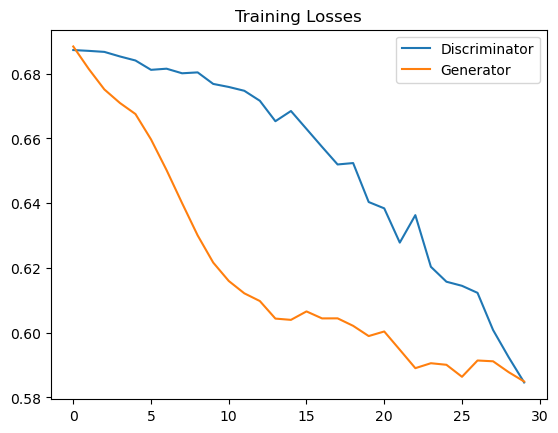

In [24]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [25]:
predictions = gan.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

71/71 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,0.038338,0.511111
std,0.032714,0.499988
min,0.000046,0.000000
25%,0.006328,0.000000
50%,0.038319,1.000000
75%,0.056121,1.000000
max,0.248673,1.000000


In [26]:
from sklearn.metrics import confusion_matrix

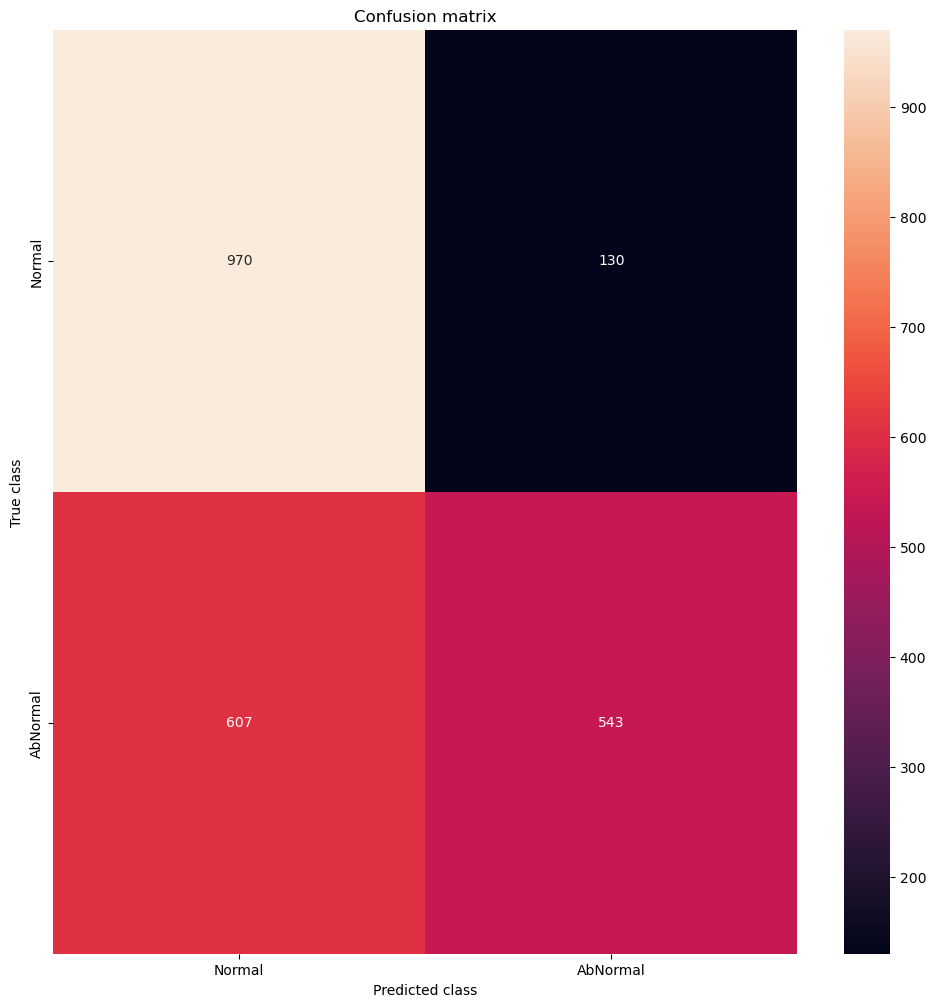


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00, 20.22it/s]

In [27]:
LABELS = ["Normal", "AbNormal"]
threshold = 0.008

y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")

plt.ylabel('True class')

plt.xlabel('Predicted class')

plt.show()

In [28]:
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.6724444444444444
Precision : 0.8068350668647846
Recall : 0.4721739130434783
F1 : 0.5957213384530993
